In [1]:
import os 
import sys
sys.path.append("../galess")
import lens_stat as ls
import ls_utils as utils
import lens_plot
import HOD

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
h = 0.7

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/giofer/anaconda3/envs/HOD/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [42]:
from scipy import integrate
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
__dP_dmu_SIE1,__dP_dmu_SIE2,__dP_dmu_SIE3,__dP_dmu_SIE4,__dP_dmu_SIE1_3,__dP_dmu_SIE3_3,__dP_dmu_SIE1_4,__w1,__w2,__w3,__w4 = ls.load_weights_dP_dmu_SIE()


def Theta_E(sigma, zl, zs):
    v_ref = 161 #km/s per SIE = 0.9 arcsec
    Ds = cosmo.angular_diameter_distance(zs).value
    Dds = cosmo.angular_diameter_distance_z1z2(zl,zs).value
    return 0.9*Dds/Ds*np.power(sigma/v_ref,2) #arcsec

def Phi_vel_disp_SDSS(sigma, zl): #from Choi et al. 2007
    from scipy.special import gamma as gammafunc
    Phi_star = 8e-3 #Mpc^-3 * h^3
    Phi_star = 8e-3*(cosmo.H0.value/100)**3 #Mpc^-3
    alpha = 2.32
    beta = 2.67
    sigma_star = 161 #km/s
    return Phi_star*np.power(sigma/sigma_star, alpha)*(np.exp(-np.power(sigma/sigma_star,beta))/gammafunc(alpha/beta))*(beta/sigma)

def Phi_vel_disp_Mason(sigma, zl): #from Mason 2015
    p = 0.24 #from Mason 2015
    beta = 0.2
    alpha_s = -0.54
    Phi_star = 3.75*1e-3 #Mpc^-3
    sigma_star = 216 #km/s
    Phi_star_z = Phi_star*np.power(1+zl,-2.46)
    sigma_z = sigma*np.power(1+zl,beta)
    return np.log(10)*1/p*(Phi_star_z/sigma_z)*np.power(sigma/sigma_star, (1+alpha_s)/p)*np.exp(-np.power(sigma/sigma_star,1/p))

def Phi_vel_disp_Geng(sigma, zl): #from Geng et al. 2021
    from scipy.special import gamma as gammafunc
    Phi_star = 8e-3 #Mpc^-3 * h^3
    Phi_star = 8e-3*(cosmo.H0.value/100)**3 #Mpc^-3
    alpha = 2.32
    beta = 2.67
    sigma_star = 161 #km/s
    nu_n = -1.2
    nu_v = 0.2
    P = -0.88
    Q = 0.09
    #Phi_star_z = Phi_star*np.power(10,P*zl)
    #sigma_star_z = sigma_star*np.power(10,Q*zl)
    Phi_star_z = Phi_star*np.power(1+zl,nu_n)
    sigma_star_z = sigma_star*np.power(1+zl,nu_v)
    return Phi_star_z*np.power(sigma/sigma_star_z, alpha)*(np.exp(-np.power(sigma/sigma_star_z,beta))/gammafunc(alpha/beta))*(beta/sigma)


def dTau_dz_dsigma(sigma, zl, zs, Phi_vel_disp = Phi_vel_disp_Mason):
    rad_to_arcsec = 1/206265
    c_sp = 299792.458 #km/s
    Hz = cosmo.H(zl).value #km s^-1 Mpc^-1
    Dd = cosmo.angular_diameter_distance(zl).value
    Ein_R = Theta_E(sigma, zl, zs)
    return Phi_vel_disp(sigma, zl)*np.power(1+zl,2)*(c_sp/Hz)*np.pi*np.power(Dd,2)*np.power(Ein_R,2)*(rad_to_arcsec**2)

def dTau_dz(zl, zs, Phi_vel_disp = Phi_vel_disp_Mason):
    #1-500km/s to integrate over
    return integrate.quad(dTau_dz_dsigma, 1, 500, args=(zl, zs, Phi_vel_disp))[0]
    
def Tau(zs, Phi_vel_disp = Phi_vel_disp_Mason):
    #0-zs redshift to integrate over
    return integrate.quad(dTau_dz, 0, zs, args=(zs, Phi_vel_disp))[0]

Tau(4)

0.0031975033528795025

In [48]:
limit_ang = 0.2

zs = 4
rad_to_arcsec = 1/206265
c_sp = 299792.458 #km/s
Phi_vel_disp = Phi_vel_disp_Mason
zl_arr = np.linspace(0, zs, 50)
sg_arr = np.linspace(100, 400, 50)
res = 0
for zl in zl_arr:
    Hz = cosmo.H(zl).value #km s^-1 Mpc^-1
    Dd = cosmo.angular_diameter_distance(zl).value
    for sigma in sg_arr:
        Ein_R = Theta_E(sigma, zl, zs)
        r = Phi_vel_disp(sigma, zl)*np.power(1+zl,2)*(c_sp/Hz)*np.pi*np.power(Dd,2)*np.power(Ein_R,2)*(rad_to_arcsec**2)
        res = res + r if (Ein_R <= limit_ang) else res

print('VDF: Mason et al. 2015')
print(f'Tau at z = 4 :{Tau(4, Phi_vel_disp):.1e}, limiting theta < 0.2": {res * np.diff(zl_arr)[0] * np.diff(sg_arr)[0]:.1e}')
print(f'Tau at z = 4 :{Tau(4, Phi_vel_disp):.1e}, limiting to naked cusp: {Tau(4, Phi_vel_disp) * __w3:.1e}')

Phi_vel_disp = Phi_vel_disp_Geng
res = 0
for zl in zl_arr:
    Hz = cosmo.H(zl).value #km s^-1 Mpc^-1
    Dd = cosmo.angular_diameter_distance(zl).value
    for sigma in sg_arr:
        Ein_R = Theta_E(sigma, zl, zs)
        r = Phi_vel_disp(sigma, zl)*np.power(1+zl,2)*(c_sp/Hz)*np.pi*np.power(Dd,2)*np.power(Ein_R,2)*(rad_to_arcsec**2)
        res = res + r if (Ein_R <= limit_ang) else res
print('VDF: Geng et al. 2021')
print(f'Tau at z = 4 :{Tau(4, Phi_vel_disp):.1e}, limiting theta < 0.2": {res * np.diff(zl_arr)[0] * np.diff(sg_arr)[0]:.1e}')
print(f'Tau at z = 4 :{Tau(4, Phi_vel_disp):.1e}, limiting to naked cusp: {Tau(4, Phi_vel_disp) * __w3:.1e}')



VDF: Mason et al. 2015
Tau at z = 4 :3.2e-03, limiting theta < 0.2": 2.8e-05
Tau at z = 4 :3.2e-03, limiting to naked cusp: 4.0e-05
VDF: Geng et al. 2021
Tau at z = 4 :1.7e-03, limiting theta < 0.2": 2.5e-05
Tau at z = 4 :1.7e-03, limiting to naked cusp: 2.1e-05


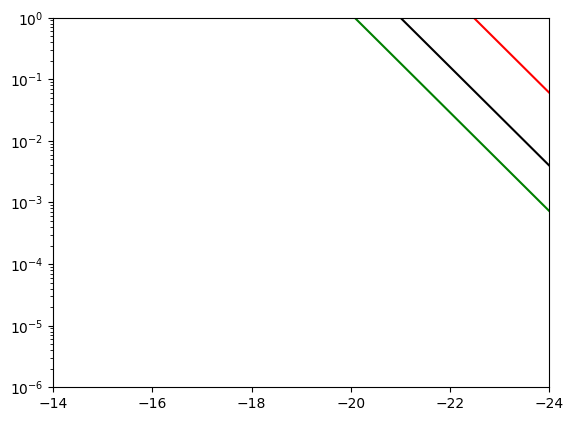

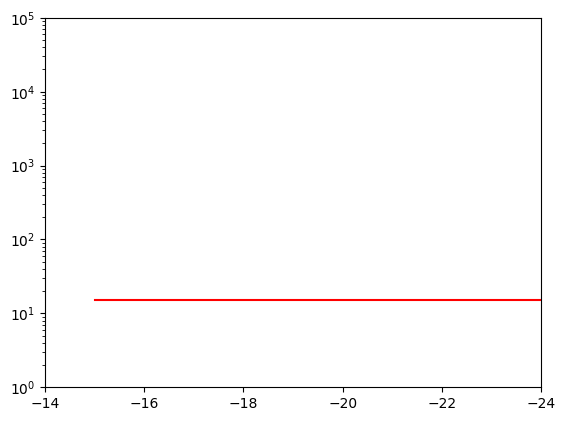

In [89]:
def pow_LF(M_int,zs, phi_0=0, Mstar=0):  ### Param from Bouwens 2022
    zt = 2.42
    phi_0 = 1
    Mstar = -21
    alpha = -3
    
    return phi_0 * np.power(10, 0.4 * (Mstar-M_int) * (alpha+1))

zs = 4

LF_FUNC = ls.schechter_LF
LF_FUNC = pow_LF

M_int = np.linspace(-15, -25, 100)
LF   = LF_FUNC(M_int, zs)
LLF1 = np.array([ls.Lensed_Point_LF_SIE(1, 1, M, LF_FUNC, zs) for M in M_int])
LLF3 = np.array([ls.Lensed_Point_LF_SIE(3, 1, M, LF_FUNC, zs) for M in M_int])

plt.plot(M_int, LF, c='k')
plt.plot(M_int, LLF1, c='r')
plt.plot(M_int, LLF3, c='g')
plt.yscale('log')
plt.xlim((-14,-24))
plt.ylim((1e-6,1))
plt.show()

plt.plot(M_int, LLF1/LF, c='r')
plt.plot(M_int, LLF3/LF, c='g')
plt.yscale('log')
plt.xlim((-14,-24))
plt.ylim((1,1e5))
plt.show()